In [1]:
from IPython import display

# Containers
`StandardE2E` provides a unified API for data processing for various end-to-end self-diving datasets. In order to handle data in a consistent and comfortable way the library comes with a set of containers that 1: facilitate unified data representation and 2: allow flexible processing and operating. The list of specific containers will expand as the library develops, however some of them are fundamental and we cover them here.
We start with very basic frame_data containers: `StandardFrameData`, `FrameIndexData`, `TransformedFrameData` and `TransformedFrameDataBatch`. Here is how the dataflow scheme looks:

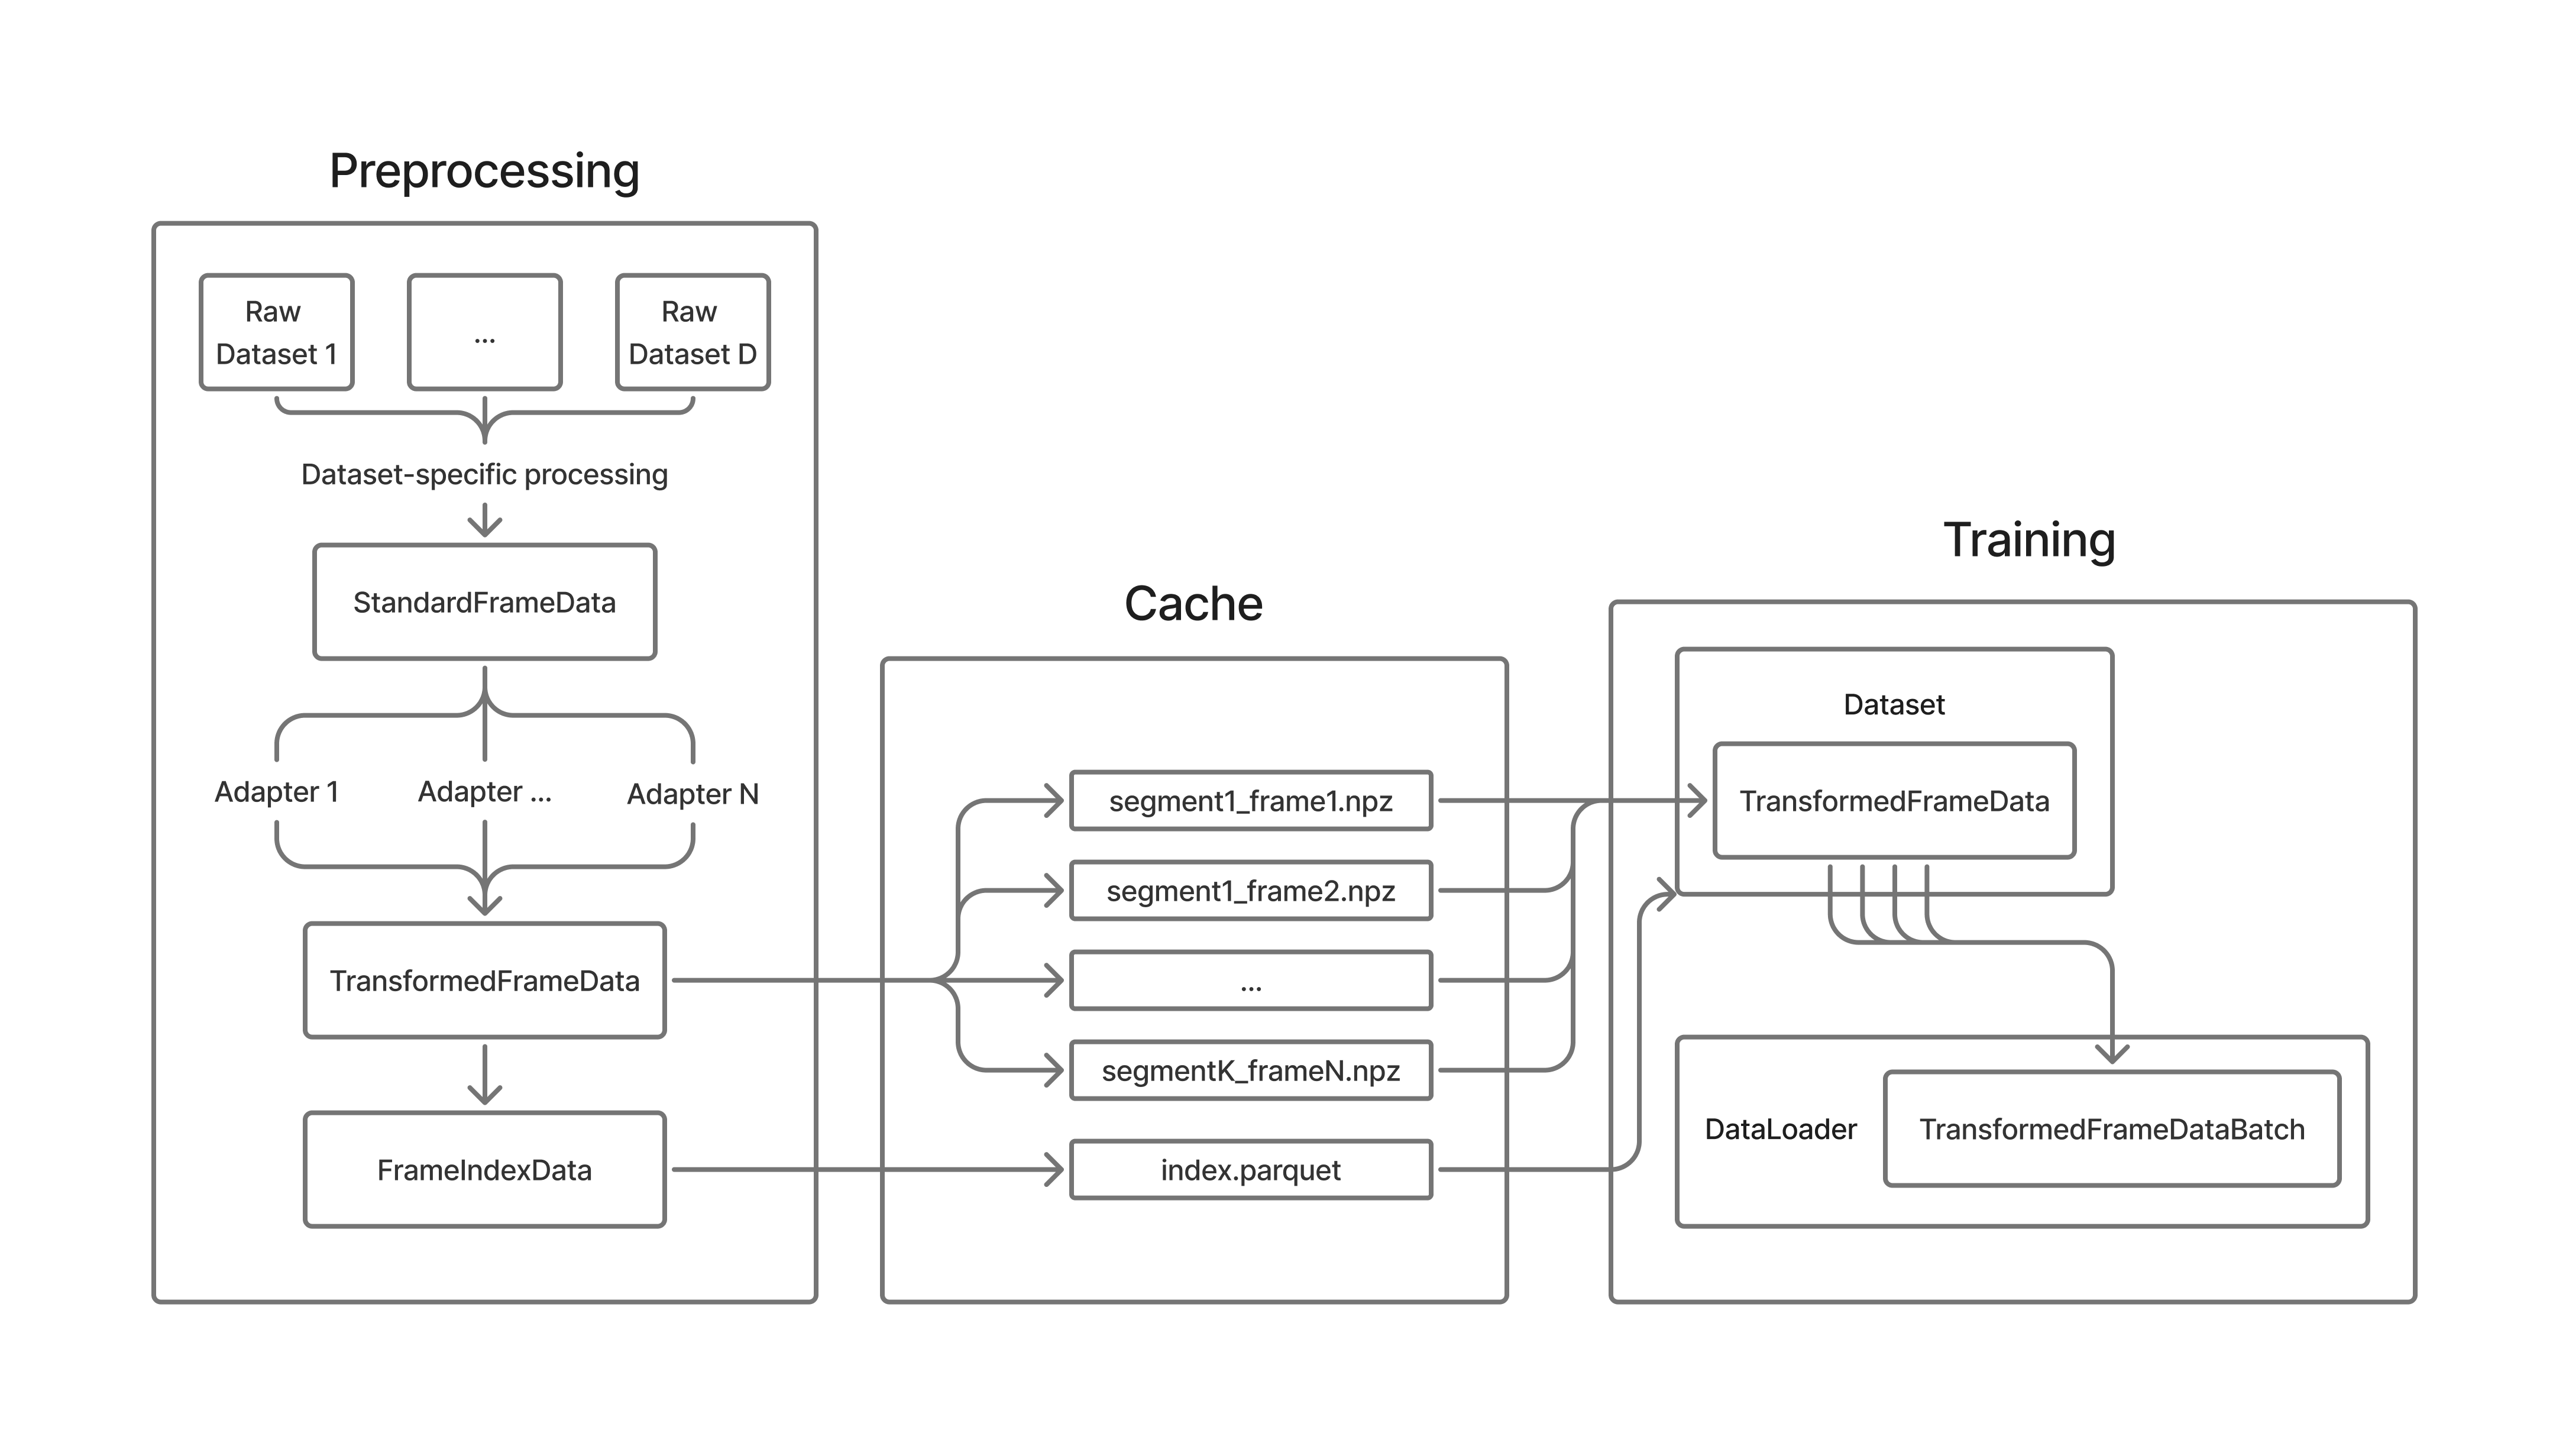

In [2]:
display.Image("../assets/standard_e2e_dataflow.png")

`TransformedFrameData` contains data representation optimized for training. It contains both processed `Modality` data and frame metadata like `dataset_name`, `split`, `segment_id`, `frame_id`, `timestamp`. Also, it can handle `aux_data` - dictionary with auxilary data and `extra_index_data` - dictionary that would be stored in index dataframe. For `extra_index_data` it is recommended to populate it with very compact data needed for indexing tasks eg. filtering, while `aux_data` is a better fit for heavy data like extra image etc. `timestamp_diff` is automatically populated during training with `timestamp_diff=0` for the current frame. `modality_defaults` are used to fill in missing values. One example where it can be particularly important is when combining `Waymo E2E` dataset that has `Modality.INTENT` and other dataset that does not have it - then in order to keep consistency we need to populate samples with missing intents with `Intent.UNKNOWN` by using `standard_e2e.dataset_utils.modality_defaults.IntentDefaults`.

`TransformedFrameDataBatch` is a class returned by DataLoader, which handles multiple `TransformedFrameData`s and also properly collates internal modalities eg. transforming `Trajectory` -> `BatchedTrajectory`.

In [ ]:
processed_data_path = "/path/to/processed/data"
config_path = "../configs/base.yaml"


In [4]:
import os
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from standard_e2e import UnifiedE2EDataset
from standard_e2e.utils import load_yaml_config
from standard_e2e.enums import Modality
from standard_e2e.indexing import get_multi_dataset_index
from standard_e2e.dataset_utils.modality_defaults import (
    IntentDefaults, PreferredTrajectoryDefaults
)
from standard_e2e.dataset_utils.augmentation import (
    MultipleFramesImageAugmentation,
    TrajectoryResampling,
)
from standard_e2e.enums import TrajectoryComponent as TC

config = load_yaml_config(config_path)

waymo_e2e_train_index = pd.read_parquet(
    os.path.join(processed_data_path, "waymo_e2e/training/index.parquet")
)
waymo_perception_train_index = pd.read_parquet(
    os.path.join(processed_data_path, "waymo_perception/training/index.parquet")
)
unified_index = get_multi_dataset_index(
    [waymo_e2e_train_index, waymo_perception_train_index]
)
history_time_lattice = np.linspace(-3, 0, 7, endpoint=True)
future_time_lattice = np.linspace(0, 5, 51)[1:]

dataset = UnifiedE2EDataset(
    processed_data_path=processed_data_path,
    feature_loaders_config=config["dataset"]["features"],
    label_loaders_config=config["dataset"]["labels"],
    index_data=unified_index,
    regime="train",
    augmentations=[
        MultipleFramesImageAugmentation("train"),
        TrajectoryResampling(
            history_target_timestamps=history_time_lattice,
            target_frame_names=["current_sensors"],
        ),
        TrajectoryResampling(
            future_target_timestamps=future_time_lattice,
            target_frame_names=["current_future_states"],
        ),
    ],
    modality_defaults={
        Modality.INTENT: IntentDefaults(),
        Modality.PREFERENCE_TRAJECTORY: PreferredTrajectoryDefaults()},
)
dataloader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=dataset.collate_fn,
    num_workers=4,
)

In [5]:
for k, v in dataset[0].items():
    print(k, type(v))

current_sensors <class 'standard_e2e.data_structures.frame_data.TransformedFrameData'>
current_future_states <class 'standard_e2e.data_structures.frame_data.TransformedFrameData'>
future_1second <class 'standard_e2e.data_structures.frame_data.TransformedFrameData'>


In [6]:
dataloader_iter = iter(dataloader)
batch = next(dataloader_iter)
for k, v in batch.items():
    print(k, type(v))

current_sensors <class 'standard_e2e.data_structures.frame_data.TransformedFrameDataBatch'>
current_future_states <class 'standard_e2e.data_structures.frame_data.TransformedFrameDataBatch'>
future_1second <class 'standard_e2e.data_structures.frame_data.TransformedFrameDataBatch'>


In [7]:
(
    dataset[0]['current_sensors'].get_modality_data(Modality.CAMERAS).shape,
    batch['current_sensors'].get_modality_data(Modality.CAMERAS).shape,
)

(torch.Size([3, 640, 640]), torch.Size([16, 3, 640, 640]))

In [8]:
(
    dataset[0]['current_sensors'].get_modality_data(Modality.PAST_STATES),
    batch['current_sensors'].get_modality_data(Modality.PAST_STATES),
)

(Trajectory(N=7, isEmpty=False,             score=None, comps=[TIMESTAMP:(7,), IS_VALID:(7,), X:(7,), Y:(7,), VELOCITY_X:(7,), VELOCITY_Y:(7,), ACCELERATION_X:(7,), ACCELERATION_Y:(7,)]),
 BatchedTrajectory(batch_size=16,                 sequence_length=7, device=cpu, components=[ACCELERATION_X:(16, 7, 1), ACCELERATION_Y:(16, 7, 1), HEADING:(16, 7, 1), IS_VALID:(16, 7, 1), TIMESTAMP:(16, 7, 1), VELOCITY_X:(16, 7, 1), VELOCITY_Y:(16, 7, 1), X:(16, 7, 1), Y:(16, 7, 1), Z:(16, 7, 1)], scores_shape=(16,), empty_mask=[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]))

In [9]:
(
    dataset[0]['current_sensors']
        .get_modality_data(Modality.PAST_STATES)
        .get([TC.X, TC.Y])
        .shape,
    batch['current_sensors']
        .get_modality_data(Modality.PAST_STATES)
        .get([TC.X, TC.Y])
        .shape,
)

((7, 2), torch.Size([16, 7, 2]))

`Trajectory` is a functional container that deserves our attention. Is is designed to carefully keep trajectory data, not only coordiantes, velocities, etc, but also score and validity flag. Namely, it does:
* storing trajectory components and operating with them in consistent and transparent way
* padding / trimming trajectories (useful in DataLoader for unified tensor size along time dinemsion)
* interpolating given trajectory for a given time lattice. It can be particularly important to keep consistency across different datasets and stabilizing training. Namely, different datasets may have different trajectory lenghts and different timedeltas between states, thus introducing same time lattice allows to overcome these complexities immidiately. This can be efficiently done with `TrajectoryResampling` augmentation or directly applying `.resampling()` method to trajectory
* automatically handling validity mask and timestamp

Custom `collation_fn` transforms `Trajectory` to `BatchedTrajectory`. `BatchedTrajectory` keeps data about multiple trajectories and automatically pads trajectories over the time dimension (also properly handling validity flag). `.get()` method outputs the torch.tensor with desired components.

In [41]:
past_states_trajectory = dataset[0]['current_sensors'].get_modality_data(Modality.PAST_STATES)
# Negative timestamps indicate history
with np.printoptions(suppress=True, precision=4):
    print(past_states_trajectory.get([TC.TIMESTAMP, TC.IS_VALID, TC.X, TC.Y]))

[[ -3.       1.     -25.9727   0.0977]
 [ -2.5      1.     -21.4961   0.0684]
 [ -2.       1.     -17.0957   0.0454]
 [ -1.5      1.     -12.7559   0.0308]
 [ -1.       1.      -8.459    0.0166]
 [ -0.5      1.      -4.2031   0.0054]
 [  0.       1.       0.       0.    ]]


In [42]:
with np.printoptions(suppress=True, precision=4):
    print(
        past_states_trajectory
        .resample(np.linspace(-4, -2, 21, endpoint=True))
        .get([TC.TIMESTAMP, TC.IS_VALID, TC.X, TC.Y]))

[[ -4.       0.       0.       0.    ]
 [ -3.9      0.       0.       0.    ]
 [ -3.8      0.       0.       0.    ]
 [ -3.7      0.       0.       0.    ]
 [ -3.6      0.       0.       0.    ]
 [ -3.5      0.       0.       0.    ]
 [ -3.4      0.       0.       0.    ]
 [ -3.3      0.       0.       0.    ]
 [ -3.2      0.       0.       0.    ]
 [ -3.1      0.       0.       0.    ]
 [ -3.       1.     -25.9727   0.0977]
 [ -2.9      1.     -25.0773   0.0918]
 [ -2.8      1.     -24.182    0.0859]
 [ -2.7      1.     -23.2867   0.0801]
 [ -2.6      1.     -22.3914   0.0742]
 [ -2.5      1.     -21.4961   0.0684]
 [ -2.4      1.     -20.616    0.0638]
 [ -2.3      1.     -19.7359   0.0592]
 [ -2.2      1.     -18.8559   0.0546]
 [ -2.1      1.     -17.9758   0.05  ]
 [ -2.       1.     -17.0957   0.0454]]


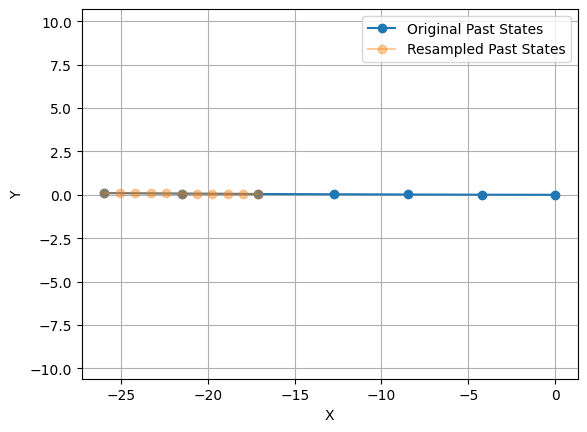

In [43]:
import matplotlib.pyplot as plt

def visualize_trajectory(trajectory, label=None, alpha=1.0):
    x = trajectory.get(TC.X)
    y = trajectory.get(TC.Y)
    is_valid = trajectory.get(TC.IS_VALID)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.axis("equal")
    plt.plot(x[is_valid == 1], y[is_valid == 1], marker='o', label=label, alpha=alpha)

visualize_trajectory(past_states_trajectory, label="Original Past States")
visualize_trajectory(
    past_states_trajectory.resample(np.linspace(-4, -2, 21, endpoint=True)),
    label="Resampled Past States", alpha=0.4
)
plt.legend()
plt.grid()